### Exploratory Data Analysis

The goal of this section is to gain an understanding of our data in order to inform what we do in the feature engineering section.  

We begin our exploratory data analysis by loading our standard modules.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

We then load the data, which we have downloaded from the Kaggle website ([here](https://www.kaggle.com/c/titanic/data) is a link to the data if you need it).

In [3]:
train = pd.read_csv(os.path.join('titanic-train.csv'))
test = pd.read_csv(os.path.join('titanic-test.csv'))

First, let's take a look at the summary of all the data. Immediately, we note that `Age`, `Cabin`, and `Embarked` have nulls that we'll have to deal with. 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


It appears that we can drop the `PassengerId` column, since it is merely an index. Note, however, that some people have reportedly improved their score with the `PassengerId` column. However, my cursory attempt to do so did not yield positive results, and moreover I would like to mimic a real-life scenario, where an index of a dataset generally has no correlation with the target variable.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Survived

So we can see that 62% of the people in the training set died. This is slightly less than the estimated 67% that died in the actual shipwreck (1500/2224).

In [6]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

/home/avinish/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

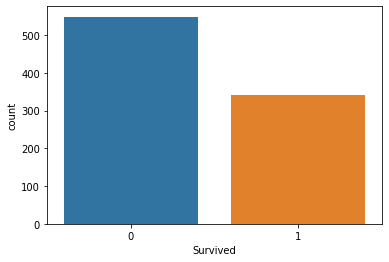

In [7]:
sns.countplot(train['Survived'])

In [9]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

/home/avinish/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='count'>

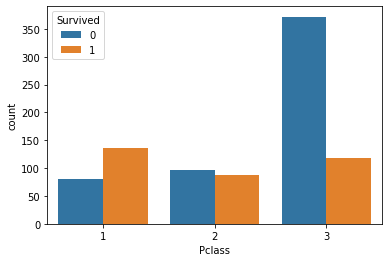

In [10]:
sns.countplot(train['Pclass'], hue=train['Survived'])

## Sex

In [11]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [12]:
train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

## Age

There are 177 nulls for `Age`, and they have a 10% lower survival rate than the non-nulls. Before imputing values for the nulls, we will include an `Age_null` flag just to make sure we can account for this characteristic of the data. 

In [13]:
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

## Embarked

Looks like the Cherbourg people had a 20% higher survival rate than the other embarking locations. This is very likely due to the high presence of upper-class passengers from that location.

In [15]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

### Model Estimation and Evaluation<a name="model"></a>

In [17]:
train.drop(['Name', 'Ticket', ''])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We are now ready to fit our model using the optimal hyperparameters. The out-of-bag score can give us an unbiased estimate of the model accuracy, and we can see that the score is 82.94%, which is only a little higher than our final leaderboard score.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

Let's take a brief look at our variable importance according to our random forest model. We can see that some of the original columns we predicted would be important in fact were, including gender, fare, and age. But we also see title, name length, and ticket length feature prominently, so we can pat ourselves on the back for creating such useful variables.

In [56]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
12,Sex_female,0.111215
11,Sex_male,0.109769
33,Name_Title_Mr.,0.109746
1,Fare,0.088209
2,Name_Len,0.087904
0,Age,0.078651
8,Pclass_3,0.043268
35,Name_Title_Miss.,0.031292
7,Ticket_Len,0.031079
34,Name_Title_Mrs.,0.028852


Our last step is to predict the target variable for our test data and generate an output file that will be submitted to Kaggle. 

In [57]:
predictions = rf.predict(test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv(os.path.join('../input', 'test.csv'))
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('y_test15.csv', sep=",", index = False)

## Conclusion

This exercise is a good example of how far basic feature engineering can take you. It is worth mentioning that I did try various other models before arriving at this one. Some of the other variations I tried were different groupings for the categorical variables (plenty more combinations remain), linear discriminant analysis on a couple numeric columns, and eliminating more variables, among other things. This is a competition with a generous allotment of submission attempts, and as a result, it's quite possible that even the leaderboard score is an overestimation of the true quality of the model, since the leaderboard can act as more of a validation score instead of a true test score. 

I welcome any comments and suggestions.